<a href="https://colab.research.google.com/github/milicasopalovic/RI_rokovi/blob/main/44.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://gitlab.com/milicasopalovic/emotion-detection.git

fatal: destination path 'emotion-detection' already exists and is not an empty directory.


In [3]:
import os

# Provera fajlova u kloniranom repozitorijumu
os.listdir('./emotion-detection')


['README.md', '.git', 'dataset']

In [4]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import load_img, img_to_array, save_img, image_dataset_from_directory
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from collections import Counter
import cv2
import imghdr
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [5]:
import os
from collections import Counter

# Putanja do dataset-a
dataset_path = "./emotion-detection/dataset/train"

# Analiza distribucije klasa
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        class_counts[class_name] = len(os.listdir(class_folder))

print("Distribucija klasa:", class_counts)


Distribucija klasa: {'disgusted': 436, 'fearful': 4097, 'surprised': 3171, 'neutral': 4965, 'sad': 4830, 'happy': 7215, 'angry': 3995}


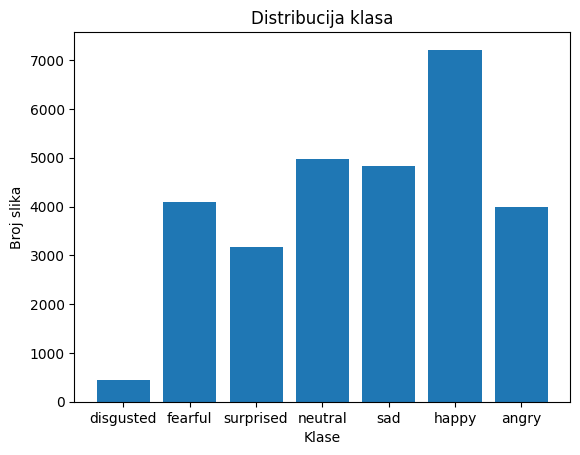

In [6]:
import matplotlib.pyplot as plt

plt.bar(class_counts.keys(), class_counts.values())
plt.title("Distribucija klasa")
plt.xlabel("Klase")
plt.ylabel("Broj slika")
plt.show()

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentacija i podela trening podataka
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2  # 20% trening podataka za validaciju
)

# Trening generator (80% trening podataka)
train_generator = train_datagen.flow_from_directory(
    "./emotion-detection/dataset/train",
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    subset='training'  # Deo za treniranje
)

# Validacioni generator (20% trening podataka)
val_generator = train_datagen.flow_from_directory(
    "./emotion-detection/dataset/train",
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    subset='validation'  # Deo za validaciju
)


test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    "./emotion-detection/dataset/test",
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical"
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Težine klasa:", class_weights)

Težine klasa: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


In [9]:
input_shape=(48, 48, 1)
num_classes = 7

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Dropout, GlobalAveragePooling2D

model = Sequential()

# Blok 1
model.add(Conv2D(filters=16, kernel_size=(7, 7), padding='same',
                 name='block1_conv1', input_shape=input_shape))
model.add(BatchNormalization(name='block1_bn1'))
model.add(Conv2D(filters=16, kernel_size=(7, 7), padding='same', name='block1_conv2'))
model.add(BatchNormalization(name='block1_bn2'))
model.add(Activation('relu', name='block1_relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same', name='block1_pool'))
model.add(Dropout(0.5, name='block1_dropout'))

# Blok 2
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', name='block2_conv1'))
model.add(BatchNormalization(name='block2_bn1'))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', name='block2_conv2'))
model.add(BatchNormalization(name='block2_bn2'))
model.add(Activation('relu', name='block2_relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same', name='block2_pool'))
model.add(Dropout(0.5, name='block2_dropout'))

# Blok 3
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='block3_conv1'))
model.add(BatchNormalization(name='block3_bn1'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='block3_conv2'))
model.add(BatchNormalization(name='block3_bn2'))
model.add(Activation('relu', name='block3_relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same', name='block3_pool'))
model.add(Dropout(0.5, name='block3_dropout'))

# Blok 4
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', name='block4_conv1'))
model.add(BatchNormalization(name='block4_bn1'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', name='block4_conv2'))
model.add(BatchNormalization(name='block4_bn2'))
model.add(Activation('relu', name='block4_relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same', name='block4_pool'))
model.add(Dropout(0.5, name='block4_dropout'))

# Blok 5
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', name='block5_conv1'))
model.add(BatchNormalization(name='block5_bn1'))
model.add(Conv2D(filters=num_classes, kernel_size=(3, 3), padding='same', name='block5_conv2'))
model.add(GlobalAveragePooling2D(name='block5_gap'))
model.add(Activation('softmax', name='predictions'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
patience = 50
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping


early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,patience=int(patience/4), verbose=1)

callbacks = [early_stop, reduce_lr]


# Treniranje
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


718/718 ━━━━━━━━━━━━━━━━━━━━ 52s 53ms/step - accuracy: 0.1610 - loss: 2.0915 - val_accuracy: 0.1730 - val_loss: 2.0216 - learning_rate: 0.0010
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 62s 38ms/step - accuracy: 0.1540 - loss: 1.9996 - val_accuracy: 0.2033 - val_loss: 1.9058 - learning_rate: 0.0010
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.1790 - loss: 1.9714 - val_accuracy: 0.1702 - val_loss: 1.9107 - learning_rate: 0.0010
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.1804 - loss: 1.9244 - val_accuracy: 0.1655 - val_loss: 1.9522 - learning_rate: 0.0010
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.1765 - loss: 1.9293 - val_accuracy: 0.2007 - val_loss: 1.8412 - learning_rate: 0.0010
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - accuracy: 0.1789 - loss: 1.9137 - val_accuracy: 0.2050 - val_loss: 1.8975 - learning_rate: 0.0010
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.1951 - loss: 1.9088

In [17]:
# Evaluacija modela na test podacima
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

# Prikaz rezultata
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4456 - loss: 1.4427
Test Loss: 1.437740445137024
Test Accuracy: 0.44831427931785583
